# Création de la nouvelle target

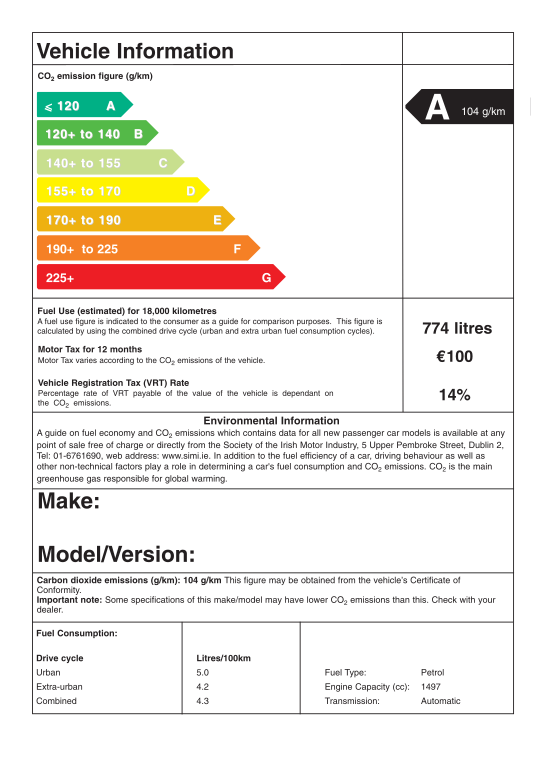

In [7]:
import pandas as pd

df = pd.read_csv('preprocessed_dataset.csv')

df["Etiquette CO2"] = df["Ewltp (g/km)"].apply(lambda x: "A" if x <= 120 else
                                                                         ("B" if x <= 140 else
                                                                          ("C" if x <= 155 else
                                                                           ("D" if x <= 170 else
                                                                            ("E" if x <= 190 else
                                                                             ("F" if x <= 225 else
                                                                              ("G")))))))

df = df.drop(axis=1, columns=['Ewltp (g/km)'])

# Encodage de la cible

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Etiquette CO2'] = label_encoder.fit_transform(df['Etiquette CO2'])

df['Etiquette CO2'].unique()

array([0, 1, 2, 3, 4, 5, 6])

# Séparation en jeu d'entrainement et jeu de test

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop(axis=1, columns=['Etiquette CO2'])
y = df['Etiquette CO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Normalisation par MinMaxScaler

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Classification

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}

for name, model in models.items():
    print(f"Évaluation du modèle : {name}")

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Score d'entraînement et de test
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Score d'entraînement : {train_score:.2f}")
    print(f"Score de test       : {test_score:.2f}")

    # Prédictions
    y_pred = model.predict(X_test)

    # Rapport de classification
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    print("Rapport de classification :")
    print(report)
    print("-" * 80)

Évaluation du modèle : Decision Tree
Score d'entraînement : 0.99
Score de test       : 0.99
Rapport de classification :
              precision    recall  f1-score   support

           A       0.99      0.99      0.99    210014
           B       0.99      0.99      0.99    201641
           C       0.98      0.99      0.98     83588
           D       0.98      0.96      0.97     25943
           E       0.99      0.97      0.98     24202
           F       0.98      0.99      0.98     20677
           G       1.00      1.00      1.00     13401

    accuracy                           0.99    579466
   macro avg       0.99      0.98      0.98    579466
weighted avg       0.99      0.99      0.99    579466

--------------------------------------------------------------------------------
Évaluation du modèle : XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:35:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Score d'entraînement : 0.99
Score de test       : 0.99
Rapport de classification :
              precision    recall  f1-score   support

           A       0.99      0.99      0.99    210014
           B       0.99      0.98      0.99    201641
           C       0.98      0.99      0.98     83588
           D       0.97      0.96      0.97     25943
           E       0.99      0.97      0.98     24202
           F       0.97      0.99      0.98     20677
           G       0.99      1.00      0.99     13401

    accuracy                           0.99    579466
   macro avg       0.98      0.98      0.98    579466
weighted avg       0.99      0.99      0.99    579466

--------------------------------------------------------------------------------
Évaluation du modèle : KNN


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

100%|===================| 4051929/4056262 [08:05<00:00]       

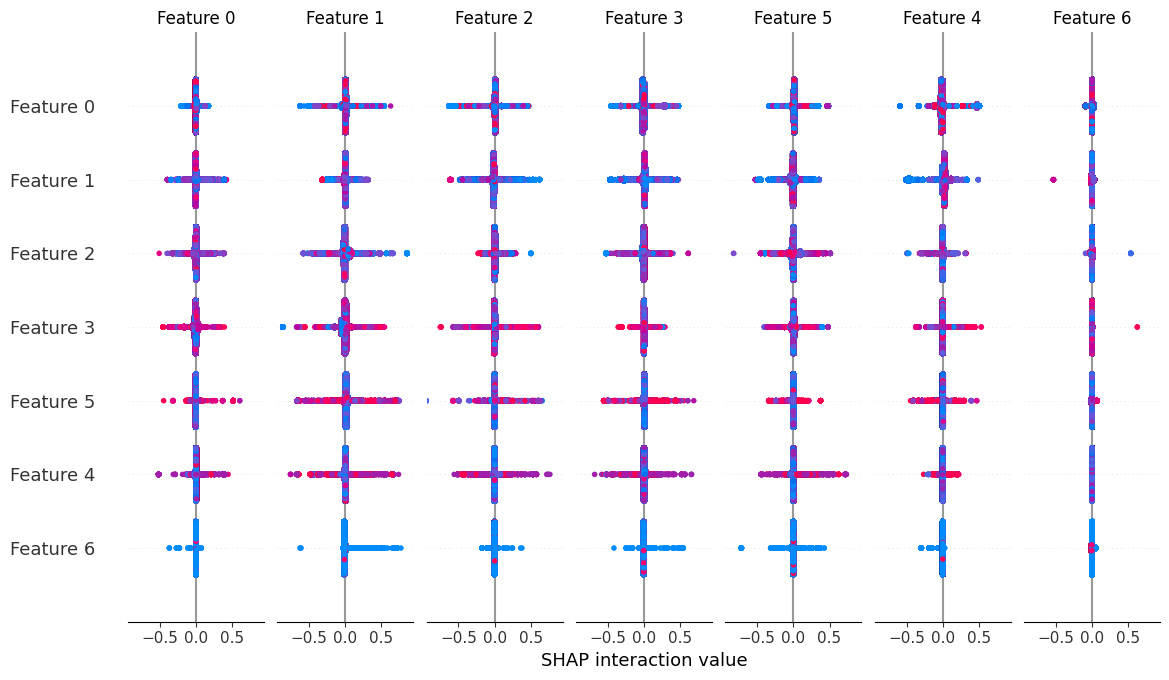

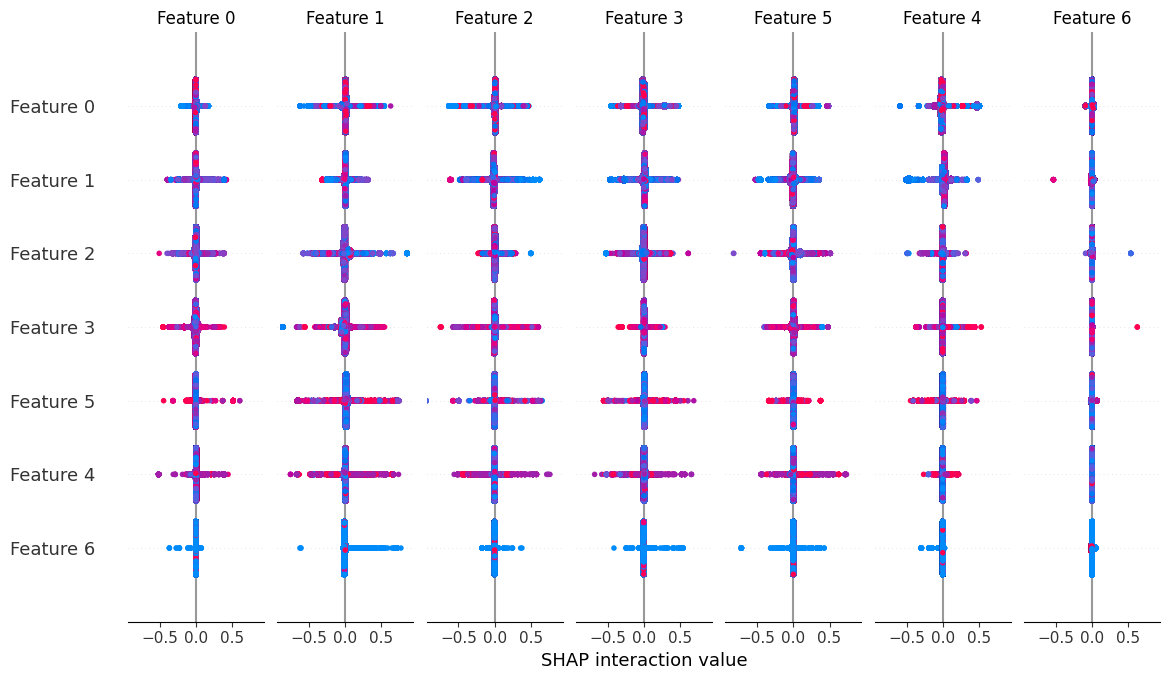

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [20]:
import shap

explainer = shap.Explainer(models['Decision Tree'], X_train)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

# Analyse détaillée pour une seule prédiction (explication locale)
index = 0
shap.force_plot(explainer.expected_value, shap_values[index].values, X_test.iloc[index])
